# Python wrapper for bcftools
Contains additional functions to mimic output of HAPSBURG for downstream analysis
@Harald Ringbauer, October 2019

In [5]:
import pandas as pd
import numpy as np
import socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./PackagesSupport/h5_python/")
from h5_functions import hdf5_to_vcf, load_h5   # Import Function to convert hdf5 to vcf
sys.path.append("./PackagesSupport/parallel_runs/")
from helper_functions import prepare_path, create_folders, postprocess_iid  # To split up ground truth ROH

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Functions to run VCF Tools for a single sample

In [30]:
def post_process_bcftools(outfile, cols = ["iid", "ch", "Start", "End", "length", "markers", "qual"]):
    """Post Process bcftools output. cols: Column Headers to use"""
    outtxt = outfile + ".txt"
    outST = outfile + "ST.txt"
    outRG = outfile + "RG.txt"
    
    !grep ^ST $outtxt > $outST
    !grep ^RG $outtxt > $outRG
    #!rm $outtxt # Clean up the now redundant original output
    
    df_pos = pd.read_csv(outST, sep='\t', header=None, usecols=range(1,6))
    df_pos.columns = ["iid", "ch", "pos", "state", "qual"]
    
    try:
        df_rohs = pd.read_csv(outRG, sep='\t', header=None, usecols=range(1,8))
        df_rohs.columns = cols
    except pd.errors.EmptyDataError:
        df_rohs = pd.DataFrame(columns = cols)  # Create empty Data Frame
        
    return df_pos, df_rohs

def run_bcftools_roh(vcf_file, outfile, mp="./Data/1000Genomes/Markers/rec_map_bcf.chr3.txt",
                    af="./Data/1000Genomes/Markers/af_1000G_EUR_bcf.chr3.txt.gz", pl=False,
                    toA = 6.7e-8, toHW=5e-9):
    """Run PLINK ROH Caller on path_vcf, and save results in outfile.txt.
    Uses Map File mp and Allele Frequency File AF (prepared in prep_map_af_bcftools.ipynb)
    Return 2 Dataframes (per site,  total roh blocks )
    pl: Whether to use Genotype Likelihoods
    toA, toHW: Rate parameters for bcftools"""
    outtxt = outfile + ".txt"
        
    if pl==False:
        !bcftools roh -G30 --AF-file $af -m $mp --hw-to-az $toA --az-to-hw $toHW $vcf_file > $outtxt
        
    elif pl==True:
        print(f"Running Genotype LL Mode on {vcf_file}...")
        !bcftools roh --AF-file $af -m $mp --hw-to-az $toA --az-to-hw $toHW $vcf_file > $outtxt
        
    # -V 1e-10   ### Command to do Viterbi Training
    
def create_hapsburg_df(df_t, map_dct):
    """Modify bcftools output to HAPSBURG format.
    Return right Dataframe"""
    df_t["StartM"] = df_t["Start"].map(map_dct)
    df_t["EndM"] = df_t["End"].map(map_dct)
    df_t["lengthM"] = df_t["EndM"] - df_t["StartM"]

    # Add all fields for roh.csv
    df_t = df_t[["Start", "End", "StartM", "EndM", "length", "lengthM", "iid", "ch"]]
    return df_t

### Quick Single Example Run on one VCF

In [3]:
%%time
vcf_file = "./Simulated/1000G_Mosaic/TSI5/ch3_6cm/data.vcf"
outfile  = "./Diverse/nosync/bcfroh_out"

run_bcftools_roh(vcf_file, outfile, pl=False)
#df_pos, df_rohs = post_process_bcftools(outfile)

#df_rohs = create_hapsburg_df(df_rohs, map_dct)

Number of target samples: 100
Number of --estimate-AF samples: 0
Number of sites in the buffer/overlap: unlimited
Number of lines overlapping with --AF-file/processed: 77652/0
Number of lines filtered/no AF/not biallelic/dup: 0/77651/0/1
No usable sites were found.
CPU times: user 10.8 ms, sys: 7.7 ms, total: 18.5 ms
Wall time: 601 ms


In [31]:
#############################################
### Combine all subfunctions

def full_bcftools_mosaic(input_base_folder, ch=3, prefix_out="bcftools/", 
                         convert_h5=True, pl=False, toA = 6.7e-8, toHW = 5e-9):
    """Run PLINK on Mosaic Data Set in ./Simulated
    convert_h5: Whether to convert from .vcf
    pl: Whether to use Genotype LL field (in conversion and analysis)
    toA, toHW: Transition Rate from HW to A, and A to HW"""
    
    print("Converting HDF5 into VCF...")
    input_h5, input_vcf, bcf_folder = create_folders(input_base_folder, outfolder="bcf_out/")
    if convert_h5:
        hdf5_to_vcf(input_h5, input_vcf, chrom=ch, pl_field=pl) # Convert to VCF
    
    print("Running bcftools/ROH...")
    outfile = bcf_folder + "bcfroh_out"
    
    run_bcftools_roh(input_vcf, outfile, pl=pl, toA=toA, toHW=toHW)   # Run BCF tools on VCF
        
    df_pos, df_rohs = post_process_bcftools(outfile) # Load the output Data
    
    ### Create the Mapping Dictionary
    print("Creating Map Dict...")
    f = load_h5(path=input_h5, output=False)
    map_dct = dict(zip(f["variants/POS"], f["variants/MAP"]))
    iids = f["samples"][:] # Get the IIDs
    
    print("Splitting up BCF results and GT...")
    df_rohs = create_hapsburg_df(df_rohs, map_dct)
    postprocess_iid(df_rohs, input_base_folder, iids, ch, prefix_out)
    print(f"Finished {len(iids)} Individuals!")

### Run bcftools on all Individuals for Mosaic Folder

In [31]:
%%time
full_bcftools_mosaic(input_base_folder = "./Simulated/1000G_Mosaic/TSI5/ch3_6cm",
                     ch=3, prefix_out="bcftools/", convert_h5=False)

Converting HDF5 into VCF...
Running bcftools/ROH...
Number of target samples: 100
Number of --estimate-AF samples: 0
Number of sites in the buffer/overlap: unlimited
Number of lines total/processed: 77652/70453
Creating Map Dict...
Splitting up BCF results and GT...
Finished 100 Individuals!
CPU times: user 18.2 s, sys: 750 ms, total: 19 s
Wall time: 28.5 s


### Run multiple lengths of copied in Chromosomes

In [ ]:
base_path =  "./Simulated/1000G_Mosaic/TSI5/"

for l in [0, 2, 4, 6, 8, 10]:
    input_base_folder = base_path + f"ch3_{l}cm"
    print(f"\nDoing ROH bcftools on {input_base_folder}...")
    full_bcftools_mosaic(input_base_folder, ch=3, prefix_out="bcftools/")

## Split up the Posterior Output for Mosaic Folders
Run to split map.csv and posterior0.csv into bcftools/ output folder

In [23]:
def post_process_postbcf(basepath, map_dct):
    """Post Process the Posterior of bcftools"""
    df_t = pd.read_csv(basepath + "bcf_out/bcfroh_outST.txt", header=None, sep="\t")
    df_t.drop(columns=0, inplace=True) # Get rid of the first component
    df_t.columns = ["iid", "chr", "pos", "state", "post"]

    ### Transfrom it from PHRED scale to posterior
    p = 10**(-df_t["post"]/10)  # prob for alternative state
    post = p * df_t["state"] + (1-p) * (1 - df_t["state"])   # 1 ROH State 0 HW
    df_t["post"] = np.log(post.values + 1e-10)
    df_t["map"] = df_t["pos"].map(map_dct)
    return df_t

def split_up_bcftools_post(basepath, df_bcf, iid, ch, prefix_out="bcftools/"):
    """Split up postprocessed Dataframe of bcftools/ROH output into
    Mosaic folders. Save map and posterior file"""
    output_base_folder = os.path.join(basepath, "output/")
    pathout = prepare_path(output_base_folder, iid, ch=3, prefix_out=prefix_out, logfile=False)
    df_t = df_bcf[df_bcf["iid"] == iid]
    
    df_map = df_t["map"]
    mappath = os.path.join(pathout,"map.csv")
    df_map.to_csv(mappath, sep=",", index=None, header=None)
    
    df_pos = df_t["post"]
    postpath = os.path.join(pathout,"posterior0.csv")
    df_pos.to_csv(postpath, sep=",", index=None, header=None)
    print(f"Saved Posterior to {postpath}")

In [ ]:
### Merge in Map(Takes about 10s)
### Create the Mapping Dictionary (Run in Wrapper Function)
input_h5 =  "./Simulated/1000G_Mosaic/TSI5/ch3_6cm/data.h5"

print("Creating Map Dict...")
f = load_h5(path = input_h5, output=False)
map_dct = dict(zip(f["variants/POS"], f["variants/MAP"]))

# Run with Genotype Likelihoods (PL field)
Everything is coded into the above functions, here it is just running them again with the right settings.
Designed to run on Readcount Data (which is getting transferred into VCFs with a PL field)

### Quick test on single file

In [19]:
%%time
path_vcf = "./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_4cm/data.vcf"
#path_vcf = "./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_4cm/data.h5"
outfile  = "./Diverse/bcfroh_outA"

run_bcftools_roh(path_vcf, outfile, pl=True, toA=0.99)
df_pos, df_rohs = post_process_bcftools(outfile)

Running Genotype LL Mode on ./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_4cm/data.vcf...
Number of target samples: 100
Number of --estimate-AF samples: 0
Number of sites in the buffer/overlap: unlimited
Number of lines overlapping with --AF-file/processed: 77650/34115
Number of lines filtered/no AF/not biallelic/dup: 0/7199/0/1
CPU times: user 1.71 s, sys: 245 ms, total: 1.96 s
Wall time: 7.44 s


### Run on full Mosaic Folder

In [18]:
%%time
full_bcftools_mosaic(input_base_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_10cm/",
                     ch=3, prefix_out="bcftools/", convert_h5=False, pl=True)

Converting HDF5 into VCF...
Running bcftools/ROH...
Running Genotype LL Mode on ./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_10cm/data.vcf...
Number of target samples: 100
Number of --estimate-AF samples: 0
Number of sites in the buffer/overlap: unlimited
Number of lines overlapping with --AF-file/processed: 77650/34100
Number of lines filtered/no AF/not biallelic/dup: 0/7199/0/1
Creating Map Dict...
Splitting up BCF results and GT...
Finished 100 Individuals!
CPU times: user 17.9 s, sys: 366 ms, total: 18.3 s
Wall time: 25.2 s


### Run multiple lengths of copied in Chromosomes and different levels of Readcounts

In [ ]:
%%time
base_path =  "./Simulated/1000G_Mosaic/TSI5/"
rc_vec = np.linspace(0.1, 1, 10)
l_vec = [0, 2, 4, 6, 8, 10]
#rc_vec = [0.5,]
# l_vec = [4,]  # To just test the power/bias  
rc_string = "lambda_rc"

### Iterate over all Readcounts and copied in Block Lengths
for rc in rc_vec:
    for l in l_vec:
        input_base_folder = base_path + rc_string + str(rc) + "/"
        input_base_folder = input_base_folder + f"ch3_{l}cm/"
        print(f"\nDoing ROH bcftools on {input_base_folder}...")
        full_bcftools_mosaic(input_base_folder, ch=3, prefix_out="bcftools100/", convert_h5=False, pl=True, 
                             toA=1e-2, toHW=1e-2)   # toA=1e-4, toHW = 5e-9

# Area 51
Area to test code

### Split up the posterior from bcftools

### Convert to VCF, storing the Genotype Likelihood

In [20]:
%%time
### Test for transformation to vcf with PL
path_h5 = "./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_6cm/data.h5"
path_vcf = "./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_6cm/data.vcf"

#hdf5_to_vcf(path_h5, path_vcf, iids=[], markers=[], chrom=3, pl_field=True)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [21]:
 f= load_h5(path_h5)

Loaded HDF5
Loaded 77650 variants
Loaded 100 individuals
['AD', 'GT']
['ALT', 'MAP', 'POS', 'REF']


In [22]:
f["calldata/GT"][0,:10,:]

array([[0, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0]], dtype=int32)

In [23]:
f["calldata/AD"][0,:10,:]

array([[1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)

In [24]:
mean_cov = np.mean(f["calldata/AD"][:,0,:])*2
print(f"Mean Coverage: {mean_cov:.6f}")

Mean Coverage: 1.000567


In [25]:
covs= np.sum(f["calldata/AD"][:,0,:], axis=1)

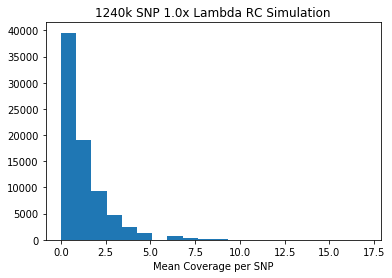

In [32]:
#import matplotlib.pyplot as plt

plt.figure()
plt.hist(covs, bins=20)
plt.xlabel("Mean Coverage per SNP")
plt.title("1240k SNP 1.0x Lambda RC Simulation")
plt.show()

In [33]:
np.mean(covs)

1.0005666452028332

In [35]:
np.mean(covs>1)

0.24551191242755957

In [11]:
df_rohs

,iid,ch,Start,End,length,markers,qual
0,iid0,3,397553,2606423,2208871,452,56.8
1,iid0,3,27180143,29998336,2818194,448,63.9
2,iid0,3,86318630,100592854,14274225,1073,80.1
3,iid0,3,156248127,165056353,8808227,1077,85.2
4,iid0,3,189828833,192291338,2462506,419,63.0
5,iid1,3,9662398,11824319,2161922,617,76.0
6,iid1,3,29164399,31733345,2568947,552,61.3
7,iid1,3,102393818,106925898,4532081,603,63.1
8,iid1,3,127120805,132065651,4944847,1040,79.0
9,iid1,3,175559562,178110386,2550825,338,43.9


In [13]:
df_rohs

,iid,ch,Start,End,length,markers,qual
0,iid0,3,397553,2606423,2208871,452,56.9
1,iid0,3,27180143,29998336,2818194,448,63.9
2,iid0,3,86318630,100592854,14274225,1073,80.3
3,iid0,3,156248127,165056353,8808227,1077,85.2
4,iid0,3,189828833,192291338,2462506,419,63.0
5,iid1,3,9662398,11824319,2161922,617,76.0
6,iid1,3,29164399,31733345,2568947,552,61.3
7,iid1,3,102393818,106985680,4591863,612,62.2
8,iid1,3,127120805,132065651,4944847,1040,79.0
9,iid1,3,175559562,178110386,2550825,338,46.1


In [18]:
df_rohs

,iid,ch,Start,End,length,markers,qual
0,iid0,3,397553,2606423,2208871,452,55.0
1,iid0,3,27180143,29998336,2818194,448,59.5
2,iid0,3,86314704,100592854,14278151,1074,80.6
3,iid0,3,156248127,165385472,9137346,1105,83.3
4,iid0,3,189828833,192291338,2462506,419,62.6
5,iid1,3,9662398,11824319,2161922,617,74.7
6,iid1,3,29035532,31784179,2748648,585,58.7
7,iid1,3,102393818,106985680,4591863,612,61.5
8,iid1,3,127120805,132065651,4944847,1040,78.6
9,iid1,3,175121109,178110386,2989278,390,33.5


In [21]:
df_rohs

,iid,ch,Start,End,length,markers,qual
0,iid0,3,397553,2606423,2208871,452,55.0
1,iid0,3,27180143,29998336,2818194,448,59.5
2,iid0,3,86314704,100592854,14278151,1074,80.6
3,iid0,3,156248127,165385472,9137346,1105,83.3
4,iid0,3,189828833,192291338,2462506,419,62.6
5,iid1,3,9662398,11824319,2161922,617,74.7
6,iid1,3,29035532,31784179,2748648,585,58.7
7,iid1,3,102393818,106985680,4591863,612,61.5
8,iid1,3,127120805,132065651,4944847,1040,78.6
9,iid1,3,175121109,178110386,2989278,390,33.5
